In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns
sns.set_theme()

import jax
import jax.numpy as jnp  
from jax import jit
from functools import partial

from jaxopt import GaussNewton

import src.terrain_mlp.fft_new.bernstein_coeff_order10_arbitinterval as bernstein_coeff_order10_arbitinterval
from src.terrain_mlp.fft_new.fn_stability_uncertain_gd import optim_cem_uneven as optim_cem_uneven

import time

import open3d as o3d

jax.config.update("jax_enable_x64", True)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
class fft_fit():

    def __init__(self):

        self.gn = GaussNewton(residual_fun=self.error_fn,maxiter=10,verbose=False,implicit_diff=True,jit=True )
        

    @partial(jit, static_argnums = (0,))
    def get_kernel(self, xy, p1, p2, p3, p4, lambdas):
        """
        Creates a fft kernel from the local point cloud patch
        """
        c_term = jnp.vstack((p1, p2))
        s_term = jnp.vstack((p3, p4))
        kernel = jnp.hstack((jnp.cos(xy@c_term), jnp.sin(xy@s_term)))
        
        pred_z = (kernel@lambdas)[:,0]

        return pred_z

    @partial(jit, static_argnums = (0,))
    def solve(self,lam,p1,p2,p3,p4,pcd):
        lamdas, state = self.gn.run(lam,p1,p2,p3,p4,pcd)
        return lamdas
    
    @partial(jit, static_argnums = (0,))
    def error_fn(self, lambdas, p1, p2, p3, p4, pcd):  
        lambdas = lambdas.reshape(-1,1)
        xy = pcd[:, :2]
        gt_z = pcd[:, -1]
        pred_z = self.get_kernel(xy, p1, p2, p3, p4, lambdas)
        error = jnp.hstack((pred_z - gt_z, 0.15*lambdas.squeeze(axis=-1)))

        return error



In [3]:
@jax.jit
def get_kernel(xy, p1, p2, p3, p4):
    c_term = jnp.vstack((p1, p2))
    s_term = jnp.vstack((p3, p4))
    kernel = jnp.hstack((jnp.cos(xy[:, :2]@c_term), jnp.sin(xy[:, :2]@s_term)))
    
    return kernel

In [4]:
@jax.jit
def compute_z(xyz_test,sampled_params,p1,p2,p3,p4):
    lam = sampled_params.reshape(-1,1)
    kernel = get_kernel(xyz_test, p1, p2, p3, p4)
    # print(jnp.max((kernel@lam)[:,0]))
    z = jnp.clip((kernel@lam)[:,0],-20.0,20.0)
    return z

In [5]:
compute_z_batch = jax.jit(jax.vmap(compute_z, in_axes=(None,0,None,None,None,None)))

In [6]:
# data = o3d.io.read_point_cloud("./src/terrain_mlp/fft_new/pcd/terr6_10m.pcd")
# data = o3d.io.read_point_cloud("./src/terrain_mlp/fft_new/ros_files/hardware_data/fused_accumulated_map.pcd")
data = o3d.io.read_point_cloud("./src/terrain_mlp/fft_new/ros_files/hardware_data/fused_clouds/fused_cloud_240.pcd")
data = data.voxel_down_sample(voxel_size=0.4)
xyz_temp = np.asarray(data.points, dtype=jnp.float32)
xyz = jnp.nan_to_num(xyz_temp,posinf=0.0,neginf=0.0)

patch_size = xyz.shape[0]

num_unknowns = 100
print(patch_size)

4619


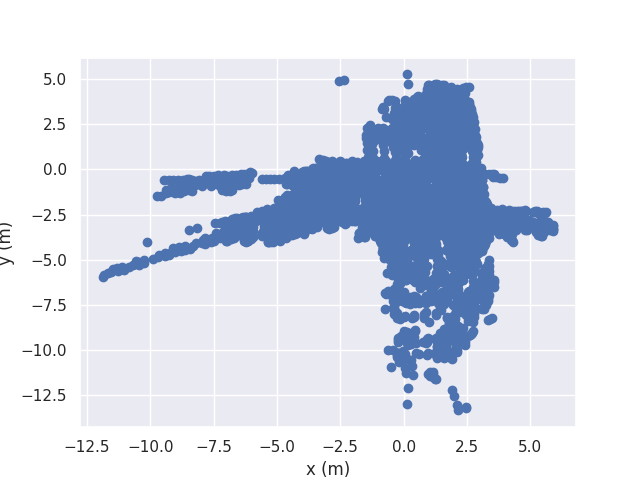

In [7]:
fig, ax = plt.subplots()
plt.rcParams["font.weight"] = "bold"
# plt.rcParams["axes.labelweight"] = "bold"
# plt.rcParams["axes.labelsize"] = 12
# plt.rcParams["xtick.labelsize"] = 12
# plt.rcParams["ytick.labelsize"] = 12
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
# ax.set_zlabel('z (m)')
# ax.set_xticks([])
# ax.set_yticks([])
# ax.set_zticks([])
# ax.plot_trisurf(pcd[:,0],pcd[:,1],pcd[:,2],cmap='viridis', alpha=1.0, zorder=1, linewidth=0.001)
ax.scatter(xyz[:,0],xyz[:,1])

plt.show()

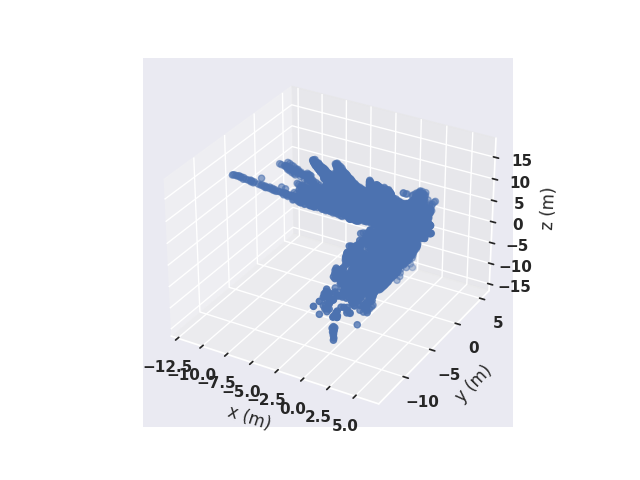

In [8]:
fig, ax = plt.subplots(subplot_kw={'projection': '3d'})
plt.rcParams["font.weight"] = "bold"
# plt.rcParams["axes.labelweight"] = "bold"
# plt.rcParams["axes.labelsize"] = 12
# plt.rcParams["xtick.labelsize"] = 12
# plt.rcParams["ytick.labelsize"] = 12
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_zlabel('z (m)')
# ax.set_xticks([])
# ax.set_yticks([])
# ax.set_zticks([])
# ax.plot_trisurf(xyz[:,0],xyz[:,1],xyz[:,2],cmap='viridis', alpha=1.0, zorder=1, linewidth=0.001)
ax.scatter3D(xyz[:,0],xyz[:,1],xyz[:,2])

plt.show()

In [9]:
t_fin = 20
num = 100
t = t_fin/num

tot_time = np.linspace(0, t_fin, num)
tot_time = tot_time
tot_time_copy = tot_time.reshape(num, 1)

P, Pdot, Pddot = bernstein_coeff_order10_arbitinterval.bernstein_coeff_order10_new(10, tot_time_copy[0], tot_time_copy[-1], tot_time_copy)

In [10]:
cem_optimizer = optim_cem_uneven(t_fin, P, Pdot, Pddot, num_unknowns)

In [11]:
batch = 1
num_points = 1

pcd = xyz

min_xy = jnp.min(pcd,axis=0)
max_xy = jnp.max(pcd,axis=0)
min_x = min_xy[0]
max_x = max_xy[0]
min_y = min_xy[1]
max_y = max_xy[1]

print(min_x,max_x)
print(min_y,max_y)

num_lamdas = 200
num_params = 100

key1 = jax.random.PRNGKey(0)
key2 = jax.random.PRNGKey(1)
key3 = jax.random.PRNGKey(2)
key4 = jax.random.PRNGKey(3)
key5 = jax.random.PRNGKey(4)

#aux_vars
p1 = jax.random.normal(key1, shape=(num_params,), dtype=jnp.float32)
p2 = jax.random.normal(key2, shape=(num_params,), dtype=jnp.float32)
p3 = jax.random.normal(key3, shape=(num_params,), dtype=jnp.float32)
p4 = jax.random.normal(key4, shape=(num_params,), dtype=jnp.float32)

fft_obj = fft_fit()

fft_start_time = time.time()

# opt_vars
lam = jax.random.normal(key5, shape=(num_lamdas,), dtype=jnp.float32)

t1 = time.time()
lam = fft_obj.solve(lam,p1,p2,p3,p4,pcd)
t2 = time.time()
print("Time to construct FFT = ", t2-t1)

z_new = fft_obj.get_kernel(pcd[:,0:2], p1, p2, p3, p4, lam.reshape(-1,1))
z_new = jnp.clip(z_new,-6.0,6.0)

error = z_new - pcd[:,2]
print("error", jnp.linalg.norm(error))

x_max = max_x #- 2
x_min = min_x #+2
y_max = max_y #- 2
y_min = min_y #+ 2

params = jnp.hstack((p1, p2, p3, p4))

lam = lam.astype(jnp.float64)
params = params.astype(jnp.float64)
pcd = pcd.astype(jnp.float64)

hess = cem_optimizer.hessian(lam,params,pcd)+jnp.eye(num_unknowns*2)*0.01

cov = jnp.linalg.inv(hess)

-11.88618 5.9160466
-13.352686 5.269272
Time to construct FFT =  1.1694436073303223
error 278.49417


In [12]:
lam = lam.reshape(-1,1)

p1 = params[0:num_unknowns]
p2 = params[num_unknowns:2*num_unknowns]
p3 = params[2*num_unknowns:3*num_unknowns]
p4 = params[3*num_unknowns:4*num_unknowns]


-20.0
20.0


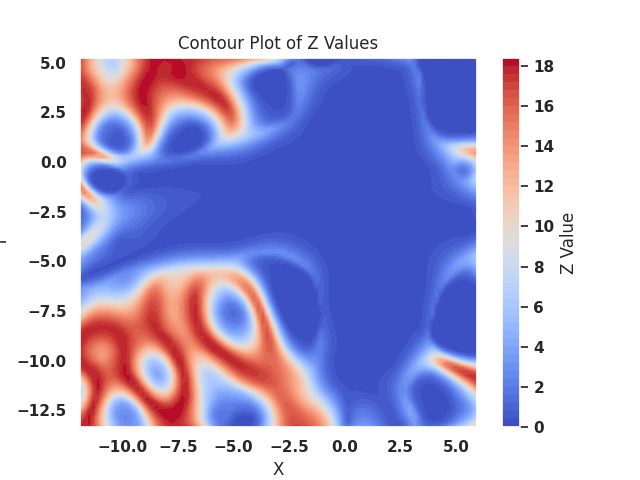

In [13]:
xs = jnp.arange(min_x,max_x,0.2, dtype=jnp.float32)
ys = jnp.arange(min_y,max_y,0.2, dtype=jnp.float32)
X,Y = jnp.meshgrid(xs,ys)
xp = X.flatten()
yp = Y.flatten()
xyz_test = jnp.vstack((xp,yp)).T


key6 = jax.random.PRNGKey(0)
key6, subkey = jax.random.split(key6)
lam = lam.squeeze(axis=-1)
sampled_lam = jax.random.multivariate_normal(subkey,lam,cov,shape=(1000,))
z_values = compute_z_batch(xyz_test[:,0:2],sampled_lam,p1,p2,p3,p4)    
print(jnp.min(z_values[:,0]))
print(jnp.max(z_values[:,0]))
std_z = jnp.std(z_values,axis=0)

plt.figure()
plt.contourf(X, Y, std_z.reshape(X.shape[0],X.shape[1]), levels=50, cmap='coolwarm')
plt.colorbar(label='Z Value')
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Contour Plot of Z Values")
# plt.legend()

plt.show()

In [14]:
kernel_pcd = get_kernel(xyz_test[:, :2], p1, p2, p3, p4)
z_pcd = jnp.clip((kernel_pcd@lam.reshape(-1,1))[:,0],-20,20)
pc_new = np.asarray([xp,yp,z_pcd]).T

pc = o3d.geometry.PointCloud()
pc.points = o3d.utility.Vector3dVector(pc_new)
pc.paint_uniform_color([0, 1, 0])

gt_pc = o3d.geometry.PointCloud()
gt_pc.points = o3d.utility.Vector3dVector(pcd)
gt_pc.paint_uniform_color([1, 0, 0])

o3d.visualization.draw_geometries([pc,gt_pc])